# This notebook demonstrates some example imagingDB usecases

First, we need to connect to thte database using a JSON file containing database login information

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
import imaging_db.filestorage.s3_storage as s3_storage

/Users/jenny.folkesson/Code/imagingDB


In [2]:
import imaging_db.database.db_operations as db_ops

importlib.reload(db_ops)
credentials_filename = "/Users/jenny.folkesson/Code/db_credentials.json"

Now we can run some queries. Let's start with listing the names of existing tables

In [64]:
with db_ops.session_scope(credentials_filename) as session:
    print(db_ops.Base.metadata.tables.keys())

dict_keys(['data_set', 'file_global', 'frames', 'frames_global'])


The main table "Project" contains the unique identifier, a description, and it's also telling us if the file as been slices or uploaded "as is".

In [4]:
# Print all existing projects with their properties
datasets = session.query(db_ops.DataSet)
for d in datasets[:5]:
    print(d.id)
    print(d.dataset_serial)
    print("Description:", d.description)
    print("Date/time:", d.date_time)
    print("Has this file been split into frames:", d.frames)
    print("Microscope:", d.microscope)
    print("Parent key:", d.parent_id)
    print("--------")

7
ML-2018-04-05-08-55-00-0001
Description: This is a blank slide for testing
Date/time: 2018-04-05 08:55:00
Has this file been split into frames: False
Microscope: None
Parent key: None
--------
8
ISP-2018-06-08-15-45-00-0001
Description: This is what I assume is a typical ome-tif file
Date/time: 2018-06-08 15:45:00
Has this file been split into frames: True
Microscope: None
Parent key: None
--------
9
ML-2018-04-05-08-55-00-0002
Description: I'm pretending this is a child of the first lif file
Date/time: 2018-04-05 08:55:00
Has this file been split into frames: False
Microscope: None
Parent key: 7
--------
10
ISP-2018-06-08-00-00-00-0002
Description: Last test file from Kevin
Date/time: 2018-06-08 00:00:00
Has this file been split into frames: True
Microscope: None
Parent key: None
--------
11
ISP-2018-06-01-00-00-00-0002
Description: New test ome tif
Date/time: 2018-06-01 00:00:00
Has this file been split into frames: True
Microscope: None
Parent key: None
--------


Next, let's print all the fields for all files in FileGlobal.
FileGlobal is the class which contains files that have been uploaded as is to S3.

In [5]:
files = session.query(db_ops.FileGlobal)
for f in files:
    # This table has a one to one mapping with Project so we can retrieve ID
    print(f.data_set.dataset_serial)
    print("Folder location in S3 bucket:", f.s3_dir)
    print(f.metadata_json)
    print("--------")

ML-2018-04-05-08-55-00-0001
Folder location in S3 bucket: raw_files/ML-2018-04-05-08-55-00-0001
{'file_origin': '/Users/jenny.folkesson/Data/microscopy/BlankSlide_DAPI_TxRed_BF_Phase.lif'}
--------
ML-2018-04-05-08-55-00-0002
Folder location in S3 bucket: raw_files/ML-2018-04-05-08-55-00-0002
{'file_origin': '/Users/jenny.folkesson/Data/microscopy/BlankSlide_DAPI_TxRed_BF_Phase.lif'}
--------


FramesGlobal contains global information for a particular file that has been split into individual frames and their global metadata:

In [6]:
frames = session.query(db_ops.FramesGlobal)
for f in frames[:5]:
    print("Number of frames:", f.nbr_frames)
    print("Image width:", f.im_width)
    print("Image height:", f.im_height)
    print("z depth in stack:", f.nbr_slices)
    print("Number of channels:", f.nbr_channels)
    print("Number of time points:", f.nbr_timepoints)
    print("Number of positions (FOVs):", f.nbr_positions)
    print("Number of color channels:", f.im_colors)
    print("Bit depth:", f.bit_depth)
    print("Folder in S3 bucket:", f.s3_dir)
    # This table has a one to one mapping with Project so we can retrieve ID
    print("Unique ID:", f.data_set.dataset_serial)
    # Not printing metadata, but it's a queryable json where all global information is stored
    print("--------")

Number of frames: 39
Image width: 2048
Image height: 2048
z depth in stack: 13
Number of channels: 3
Number of time points: 1
Number of positions (FOVs): 1
Number of color channels: 1
Bit depth: uint16
Folder in S3 bucket: raw_frames/ISP-2018-06-08-15-45-00-0001
Unique ID: ISP-2018-06-08-15-45-00-0001
--------
Number of frames: 241
Image width: 2048
Image height: 2048
z depth in stack: 241
Number of channels: 1
Number of time points: 1
Number of positions (FOVs): 1
Number of color channels: 1
Bit depth: uint16
Folder in S3 bucket: raw_frames/ISP-2018-06-08-00-00-00-0002
Unique ID: ISP-2018-06-08-00-00-00-0002
--------
Number of frames: 26
Image width: 2048
Image height: 2048
z depth in stack: 13
Number of channels: 2
Number of time points: 1
Number of positions (FOVs): 1
Number of color channels: 1
Bit depth: uint16
Folder in S3 bucket: raw_frames/ISP-2018-06-01-00-00-00-0002
Unique ID: ISP-2018-06-01-00-00-00-0002
--------
Number of frames: 26
Image width: 2048
Image height: 2048
z de

The next table for sliced data is "Frames", which contains frame specific information.
This table has a many to one mapping with *FramesGlobal*.

In [7]:
# print first 5 frames
frame_info = session.query(db_ops.Frames)
for i in frame_info[0:5]:
    print(i.id)
    print("Channel index:", i.channel_idx)
    print("Slice (z) index:", i.slice_idx)
    print("Time index:", i.time_idx)
    print("Position index:", i.pos_idx)
    print("Channel name:", i.channel_name)
    print("File name:", i.file_name)
    # Since Frames has a many to one mapping to FramesGlobal, we can easily retrieve info from there
    print("Total number of frames in file:", i.frames_global.nbr_frames)
    # FramesGlobal in turn has a one to one mapping to Project, so from a Slice we can get project info:
    print("Project ID:", i.frames_global.data_set.dataset_serial)
    print("Sha256:", i.sha256)
    print("------------------------------------")

96732
Channel index: 0
Slice (z) index: 8
Time index: 0
Position index: 0
Channel name: None
File name: im_c000_z008_t000_p000.png
Total number of frames in file: 80
Project ID: ML-2018-11-01-12-28-56-0001
Sha256: 138bbe97c05839241bd7f9c724598eca6ca3c24e2b91cfe4c238c8c23156c0d5
------------------------------------
15909
Channel index: 1
Slice (z) index: 29
Time index: 0
Position index: 9
Channel name: FITC
File name: im_c001_z029_t000_p009.png
Total number of frames in file: 3276
Project ID: ISP-2018-08-27-10-00-00-0002
Sha256: b94db341f74708d98cee2b31492d469e534d5c5c6b65f94651e680e770be73e1
------------------------------------
43614
Channel index: 0
Slice (z) index: 35
Time index: 0
Position index: 0
Channel name: None
File name: im_c000_z035_t000_p000.png
Total number of frames in file: 78
Project ID: ML-2018-11-06-09-32-17-0001
Sha256: 1cffb2383cafe619a7a70efc34ca948a6b4b8a8e8cc827be02f6e1a1b90e2ee8
------------------------------------
43615
Channel index: 1
Slice (z) index: 35
Time

Some other examples of queries:
Find all data sets which have been split into frames.

In [8]:
datasets = session.query(db_ops.DataSet).filter(db_ops.DataSet.frames == True).all()
print("Nbr datasets split into frames:", len(datasets))
# Print first 5
for d in datasets[:5]:
    print(d.id)
    print(d.dataset_serial)
    print("Description:", d.description)
    print("Is it split into frames:", d.frames)
    print("Parent key:", d.parent_id)
    print("--------")

Nbr datasets split into frames: 959
8
ISP-2018-06-08-15-45-00-0001
Description: This is what I assume is a typical ome-tif file
Is it split into frames: True
Parent key: None
--------
10
ISP-2018-06-08-00-00-00-0002
Description: Last test file from Kevin
Is it split into frames: True
Parent key: None
--------
11
ISP-2018-06-01-00-00-00-0002
Description: New test ome tif
Is it split into frames: True
Parent key: None
--------
12
ISP-2018-06-01-00-00-00-0003
Description: Same as 002
Is it split into frames: True
Parent key: 11
--------
13
SMS-2018-07-03-18-35-00-0010
Description: Only 10 frames from each channel at position 0 from larger background corrected dataset
Is it split into frames: True
Parent key: None
--------


Get all unique channel names for data sets split into frames:

In [9]:
for value in session.query(db_ops.Frames.channel_name).distinct():
    print(value)

(None,)
('488',)
('DAPI',)
('568',)
('C',)
('405',)
('G',)
('Retardance',)
('Cy3',)
('Transmission',)
('T',)
('FITC',)
('Orientation',)
('A',)
('Cy5',)


Now let's get into joint queries. 

A typical usecase would be to get the S3 storage paths for all slices from a known dataset ID.
In this example we only want to retrieve the files from a specific channel named FITC.

We can get this information by joining tables Frames, FramesGlobal, and DataSet

Let's start off with just getting the first query result.

In [66]:
dataset_identifier = "ISP-2018-06-08-15-45-00-0001"
channel_name = "FITC"

first_frame = session.query(db_ops.Frames) \
    .join(db_ops.FramesGlobal) \
    .join(db_ops.DataSet) \
    .filter(db_ops.DataSet.dataset_serial == dataset_identifier) \
    .filter(db_ops.Frames.channel_name == channel_name) \
    .first()

s3_dir = first_frame.frames_global.s3_dir
print(s3_dir)
print(first_frame.file_name)

raw_frames/ISP-2018-06-08-15-45-00-0001
im_c001_z000_t000_p001.png


Let's fetch it from the S3 storage and plot it.

Im uint16 (2048, 2048)


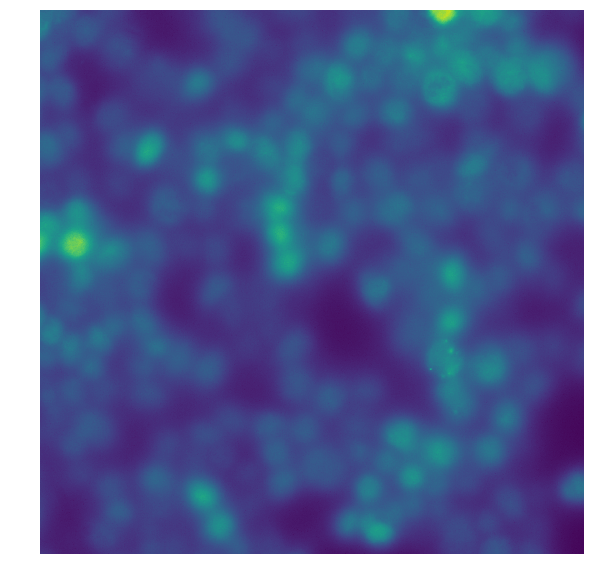

In [67]:
data_loader = s3_storage.DataStorage(s3_dir=s3_dir)

im = data_loader.get_im(first_frame.file_name)
print("Im", im.dtype, im.shape)
plt.imshow(im)
plt.rcParams['figure.figsize'] = [10, 10]
plt.axis('off')
plt.show()

Here we do the same query but instead of fetching just the first result, we fetch all.

In [70]:
all_frames = session.query(db_ops.Frames) \
    .join(db_ops.FramesGlobal) \
    .join(db_ops.DataSet) \
    .filter(db_ops.DataSet.dataset_serial == dataset_identifier) \
    .filter(db_ops.Frames.channel_name == channel_name) \
    .order_by(db_ops.Frames.file_name) \
    .all()

stack_shape = (
    all_frames[0].frames_global.im_width,
    all_frames[0].frames_global.im_height,
    all_frames[0].frames_global.im_colors,
    len(all_frames),
)
print("Stack shape:", stack_shape)
bit_depth = all_frames[0].frames_global.bit_depth
print("Bit depth:", bit_depth)
file_names = []
for f in all_frames:
    file_names.append(f.file_name)
    print(f.file_name)

Stack shape: (2048, 2048, 1, 13)
Bit depth: uint16
im_c001_z000_t000_p001.png
im_c001_z001_t000_p001.png
im_c001_z002_t000_p001.png
im_c001_z003_t000_p001.png
im_c001_z004_t000_p001.png
im_c001_z005_t000_p001.png
im_c001_z006_t000_p001.png
im_c001_z007_t000_p001.png
im_c001_z008_t000_p001.png
im_c001_z009_t000_p001.png
im_c001_z010_t000_p001.png
im_c001_z011_t000_p001.png
im_c001_z012_t000_p001.png


Now we can fetch that data from the S3 bucket where they're stored. Plot the first image again.

(2048, 2048, 1, 13)
uint16
24506 272


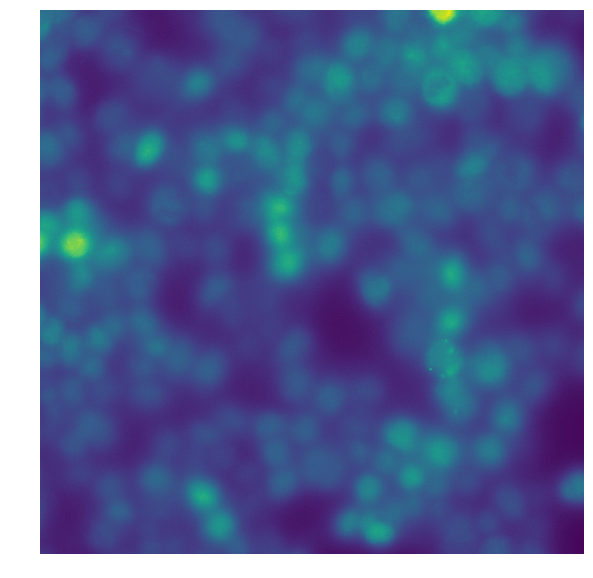

In [14]:
im_stack = data_loader.get_stack(file_names, stack_shape, bit_depth)

print(im_stack.shape)
print(im_stack.dtype)
print(im_stack.max(), im_stack.min())

# Get rid of singleton dimensions in case of grayscale images
im_stack = np.squeeze(im_stack)

plt.imshow(im_stack[..., 0])
plt.rcParams['figure.figsize'] = [10, 10]
plt.axis('off')
plt.show()

Retrieve metadata from dataset and load an image stack using metadata

In [33]:
db_ops = db_ops.DatabaseOperations(
    credentials_filename,
    dataset_serial="ISP-2018-06-01-00-00-00-0002",
)
global_meta, frames_meta = db_ops.get_frames_meta(channels=(1,))
print(global_meta)

{'s3_dir': 'raw_frames/ISP-2018-06-01-00-00-00-0002', 'nbr_frames': 26, 'im_width': 2048, 'im_height': 2048, 'nbr_slices': 13, 'nbr_channels': 2, 'im_colors': 1, 'nbr_timepoints': 1, 'nbr_positions': 1, 'bit_depth': 'uint16', 'metadata_json': {'IJMetadata': {'ROI': [0, 0, 2048, 2048], 'UUID': 'eede2dbf-80e0-4900-9a6a-ee28eb8ba5fc', 'Depth': 2, 'Width': 2048, 'Frames': 1, 'Height': 2048, 'IJType': 1, 'Prefix': 'ISP_293T_TFRC_blank_20180601_1', 'Slices': 13, 'Source': 'Micro-Manager', 'ChNames': ['DAPI', 'Cy3'], 'Comment': '', 'GridRow': 0, 'BitDepth': 16, 'ChColors': [-10066177, -205], 'Channels': 2, 'UserName': 'insituscope', 'Directory': 'C:\\Users\\InSituScope\\Desktop\\ISP-2018-06-01-001', 'PixelType': 'GRAY16', 'Positions': 6, 'TimeFirst': False, 'z-step_um': 0.7999999999999998, 'GridColumn': 0, 'Interval_ms': 0, 'PixelAspect': 1, 'SlicesFirst': True, 'ComputerName': 'BioEInSituTranscript1', 'PixelSize_um': 0, 'CameraTimeout': 20000, 'ChContrastMax': [65536, 65536], 'ChContrastMin'

In [34]:
# Print local metadata for each frame
print(frames_meta)

   channel_idx slice_idx time_idx channel_name                   file_name  \
0            1         0        0          Cy3  im_c001_z000_t000_p002.png   
1            1         1        0          Cy3  im_c001_z001_t000_p002.png   
2            1         2        0          Cy3  im_c001_z002_t000_p002.png   
3            1         3        0          Cy3  im_c001_z003_t000_p002.png   
4            1         4        0          Cy3  im_c001_z004_t000_p002.png   
5            1         5        0          Cy3  im_c001_z005_t000_p002.png   
6            1         6        0          Cy3  im_c001_z006_t000_p002.png   
7            1         7        0          Cy3  im_c001_z007_t000_p002.png   
8            1         8        0          Cy3  im_c001_z008_t000_p002.png   
9            1         9        0          Cy3  im_c001_z009_t000_p002.png   
10           1        10        0          Cy3  im_c001_z010_t000_p002.png   
11           1        11        0          Cy3  im_c001_z011_t00

In [57]:
import time
# Get image stack from metadata
importlib.reload(s3_storage)
data_loader = s3_storage.DataStorage(s3_dir=global_meta["s3_dir"])
t0 = time.time()
im_stack, dim_order = data_loader.get_stack_from_meta(global_meta, frames_meta)
print("Time to load stack: {:.2f}".format(time.time() - t0))
print("Dimensions and order:", dim_order)
print(im_stack.shape)

Time to load stack: 3.94
Dimensions and order: XYZ
(2048, 2048, 13)


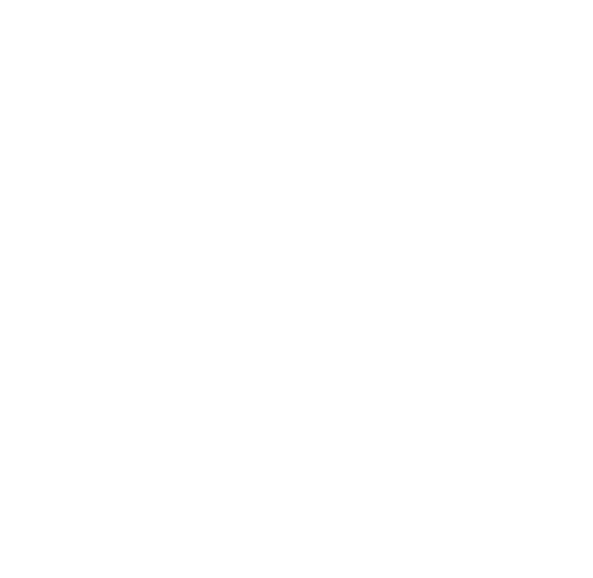

In [58]:
import matplotlib.animation as animation
from IPython.display import HTML


# Plot a flythrough of the first channel
fig = plt.figure()
plt.rcParams['figure.figsize'] = [10, 10]
plt.axis('off')

frames = []
for i in range(im_stack.shape[2]):
    frame = plt.imshow(im_stack[:, :, i], animated=True)
    frames.append([frame])

anim = animation.ArtistAnimation(fig, frames)

# Call function to display the animation
HTML(anim.to_html5_video())

In [59]:
session.rollback()
session.close()